##Задача

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

##Наименование файлов с данными

course_project_train.csv - обучающий датасет
course_project_test.csv - тестовый датасет

##Целевая переменная

Credit Default - факт невыполнения кредитных обязательств

##Метрика качества

F1-score (sklearn.metrics.f1_score)

###Подключение библиотек и скриптов

In [1]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams.update({'font.size':10})

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgbm

In [3]:
import warnings
warnings.filterwarnings ('ignore')

In [4]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [5]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [6]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (9, 4))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=2)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=2)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=2)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.1, 0.1))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [7]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(7,4))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

### Пути к директориям и файлам

In [8]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'
MPozdnyakova_predictions = 'MPozdnyakova_predictions.csv'

##Описание датасета
Home Ownership - домовладение

Annual Income	- годовой доход

Years in current job - лет на текущем месте работы	

Tax Liens	- налог

Number of Open Accounts	- количество открытых счетов

Years of Credit History - лет кредитной истории

Maximum Open Credit	- максимальный открытый кредит

Number of Credit Problems - количество кредитных проблем

Months since last delinquent - месяцев с момента последнего правонарушения

Bankruptcies - банкротства

Purpose	- цель

Term - срок

Current Loan Amount - текущая сумма кредита	

Current Credit Balance - текущий кредитный баланс

Monthly Debt -ежемесячный платёж

Credit Score - кредитный реётинг

Credit Default - кредитный дефолт

In [9]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [10]:
train_df.shape

(7500, 17)

In [11]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [14]:
train_df['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [15]:
for colname in ['Tax Liens', 'Number of Credit Problems', 'Bankruptcies']:
  train_df[colname] = train_df[colname].astype(str)

In [16]:
train_df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                        object
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems        object
Months since last delinquent    float64
Bankruptcies                     object
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [17]:
for colname in ['Tax Liens', 'Number of Credit Problems', 'Bankruptcies']:
  test_df[colname] = test_df[colname].astype(str)

In [18]:
test_df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                        object
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems        object
Months since last delinquent    float64
Bankruptcies                     object
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
dtype: object

In [19]:
train_df.describe()

,Annual Income,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Months since last delinquent,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7.500000e+03,3419.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,11.130933,18.317467,9.451537e+05,34.692600,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,4.908924,7.041946,1.602622e+07,21.688806,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,2.000000,4.000000,0.000000e+00,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,8.000000,13.500000,2.792295e+05,16.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,10.000000,17.000000,4.781590e+05,32.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,14.000000,21.800000,7.935015e+05,50.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,43.000000,57.700000,1.304726e+09,118.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [20]:
test_df.describe()

,Annual Income,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Months since last delinquent,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2.500000e+03,1142.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,11.184400,18.325920,7.105704e+05,34.181261,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,4.852774,7.254659,1.511983e+06,22.024277,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,1.000000,3.900000,0.000000e+00,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,8.000000,13.400000,2.785860e+05,16.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,10.000000,17.000000,4.786760e+05,30.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,14.000000,22.100000,8.025985e+05,50.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,48.000000,53.400000,5.448439e+07,82.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


###Обработка пропусков

In [21]:
(len(train_df) - train_df.count())/len(train_df)

Home Ownership                  0.000000
Annual Income                   0.207600
Years in current job            0.049467
Tax Liens                       0.000000
Number of Open Accounts         0.000000
Years of Credit History         0.000000
Maximum Open Credit             0.000000
Number of Credit Problems       0.000000
Months since last delinquent    0.544133
Bankruptcies                    0.000000
Purpose                         0.000000
Term                            0.000000
Current Loan Amount             0.000000
Current Credit Balance          0.000000
Monthly Debt                    0.000000
Credit Score                    0.207600
Credit Default                  0.000000
dtype: float64

In [22]:
(len(test_df) - test_df.count())/len(test_df)

Home Ownership                  0.0000
Annual Income                   0.2052
Years in current job            0.0344
Tax Liens                       0.0000
Number of Open Accounts         0.0000
Years of Credit History         0.0000
Maximum Open Credit             0.0000
Number of Credit Problems       0.0000
Months since last delinquent    0.5432
Bankruptcies                    0.0000
Purpose                         0.0000
Term                            0.0000
Current Loan Amount             0.0000
Current Credit Balance          0.0000
Monthly Debt                    0.0000
Credit Score                    0.2052
dtype: float64

In [23]:
train_df['Annual Income'].median()

1168386.0

In [24]:
test_df['Annual Income'].median()

1178475.0

In [25]:
train_df.loc[train_df['Annual Income'].isnull(), 'Annual Income'] = train_df['Annual Income'].median()

In [26]:
train_df['Years in current job'] = train_df['Years in current job'].fillna(train_df['Years in current job'].mode()[0])

In [27]:
train_df.loc[train_df['Months since last delinquent'].isnull(), 'Months since last delinquent'] = train_df['Years in current job'].fillna(0)

In [28]:
train_df.loc[train_df['Credit Score'].isnull(), 'Credit Score'] = train_df['Credit Score'].median()

In [29]:
(len(train_df) - train_df.count())/len(train_df)

Home Ownership                  0.0
Annual Income                   0.0
Years in current job            0.0
Tax Liens                       0.0
Number of Open Accounts         0.0
Years of Credit History         0.0
Maximum Open Credit             0.0
Number of Credit Problems       0.0
Months since last delinquent    0.0
Bankruptcies                    0.0
Purpose                         0.0
Term                            0.0
Current Loan Amount             0.0
Current Credit Balance          0.0
Monthly Debt                    0.0
Credit Score                    0.0
Credit Default                  0.0
dtype: float64

In [30]:
test_df.loc[test_df['Annual Income'].isnull(), 'Annual Income'] = test_df['Annual Income'].median()

In [31]:
test_df['Years in current job'] = test_df['Years in current job'].fillna(test_df['Years in current job'].mode()[0])

In [32]:
test_df.loc[test_df['Months since last delinquent'].isnull(), 'Months since last delinquent'] = test_df['Years in current job'].fillna(0)

In [33]:
test_df.loc[test_df['Credit Score'].isnull(), 'Credit Score'] = test_df['Credit Score'].median()

In [34]:
(len(test_df) - test_df.count())/len(test_df)

Home Ownership                  0.0
Annual Income                   0.0
Years in current job            0.0
Tax Liens                       0.0
Number of Open Accounts         0.0
Years of Credit History         0.0
Maximum Open Credit             0.0
Number of Credit Problems       0.0
Months since last delinquent    0.0
Bankruptcies                    0.0
Purpose                         0.0
Term                            0.0
Current Loan Amount             0.0
Current Credit Balance          0.0
Monthly Debt                    0.0
Credit Score                    0.0
dtype: float64

###Выделение целевой переменной и групп признаков

In [35]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = train_df.columns.drop(TARGET_NAME).tolist()
BASE_FEATURE_NAMES_ = test_df.columns.tolist()

###Анализ данных

In [36]:
train_df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

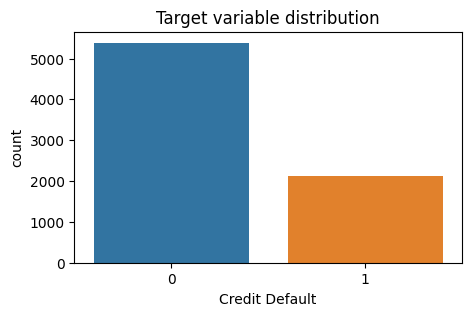

In [37]:
plt.figure(figsize=(5, 3))

sns.countplot(x=TARGET_NAME, data=train_df)

plt.title('Target variable distribution')
plt.show()

###Корреляция с базовыми признаками

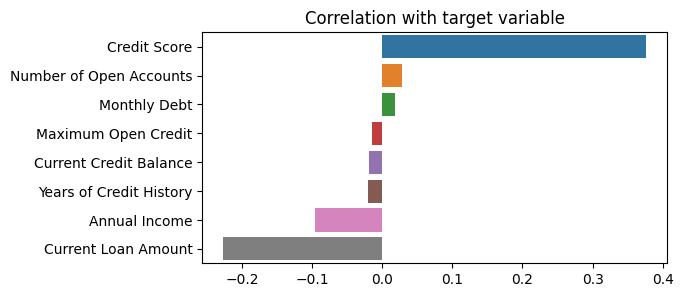

In [38]:
corr_with_target = train_df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(6, 3))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

###Отбор признаков

In [39]:
train_df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                        object
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems        object
Months since last delinquent     object
Bankruptcies                     object
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [40]:
NUM_FEATURE_NAMES = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']
CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Tax Liens', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term']
SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES

In [41]:
NUM_FEATURE_NAMES_ = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']
CAT_FEATURE_NAMES_ = ['Home Ownership', 'Years in current job', 'Tax Liens', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term']
SELECTED_FEATURE_NAMES_ = NUM_FEATURE_NAMES_ + CAT_FEATURE_NAMES_

###Нормализация данных

In [42]:
scaler = StandardScaler()

train_df_norm = train_df.copy()
train_df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(train_df_norm[NUM_FEATURE_NAMES])

train_df = train_df_norm.copy()

In [43]:
scaler = StandardScaler()

test_df_norm = test_df.copy()
test_df_norm[NUM_FEATURE_NAMES_] = scaler.fit_transform(test_df_norm[NUM_FEATURE_NAMES_])

test_df = test_df_norm.copy()

###Разбиение на train и test

In [44]:
X = train_df[NUM_FEATURE_NAMES]
y = train_df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

###Балансировка целевой переменной

In [45]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [46]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

###Построение и оценка модели

In [47]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      3771
           1       0.94      0.88      0.91      2958

    accuracy                           0.92      6729
   macro avg       0.93      0.92      0.92      6729
weighted avg       0.92      0.92      0.92      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.83      0.81      1616
           1       0.51      0.46      0.49       634

    accuracy                           0.73      2250
   macro avg       0.66      0.64      0.65      2250
weighted avg       0.72      0.73      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1340  276
1                342  292


In [48]:
from lightgbm.sklearn import LGBMClassifier
model_lgbm = lgbm.LGBMClassifier(class_weight={0:1, 1:3.5}, silent=True, random_state=21)

###Подбор гиперпараметров

In [49]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7]}

In [50]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [51]:
%%time

rs = RandomizedSearchCV(model_lgbm, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

CPU times: user 744 ms, sys: 88.4 ms, total: 832 ms
Wall time: 28.5 s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   estimator=LGBMClassifier(class_weight={0: 1, 1: 3.5},
                                            random_state=21, silent=True),
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000, 1200, 1500]},
                   scoring='f1')

In [52]:
rs.best_params_

{'n_estimators': 100, 'max_depth': 3}

In [53]:
rs.best_score_

0.5292016972345005

### Проверка качесTва, борьба с переобучением

In [54]:
final_model = lgbm.LGBMClassifier(n_estimators=100, max_depth=5,
                                      reg_lambda=40,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.85      0.79      3771
           1       0.76      0.61      0.68      2958

    accuracy                           0.74      6729
   macro avg       0.75      0.73      0.73      6729
weighted avg       0.75      0.74      0.74      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1616
           1       0.52      0.52      0.52       634

    accuracy                           0.73      2250
   macro avg       0.66      0.66      0.66      2250
weighted avg       0.73      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1308  308
1                306  328


In [55]:
# final_model = lgbm.LGBMClassifier(n_estimators=1000, max_depth=3,
#                                       class_weight={0:1, 1:3.5},
#                                       silent=True, random_state=21)

In [56]:
# %%time

# final_model = lgbm.LGBMClassifier(n_estimators=1000, max_depth=3,
#                                       silent=True, random_state=21)
# final_model.fit(X_train, y_train)

# y_train_pred = final_model.predict(X_train)
# y_test_pred = final_model.predict(X_test)

# get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

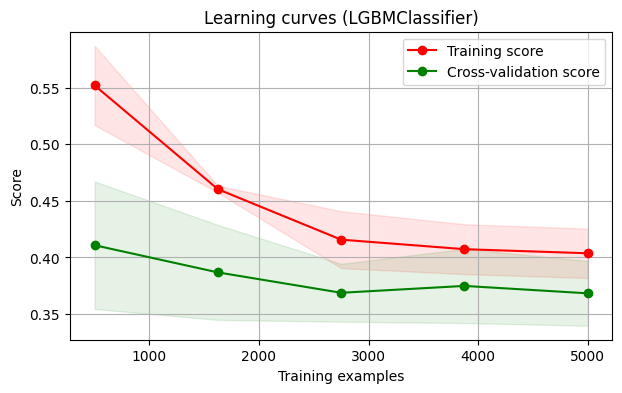

In [57]:
show_learning_curve_plot(final_model, X, y)

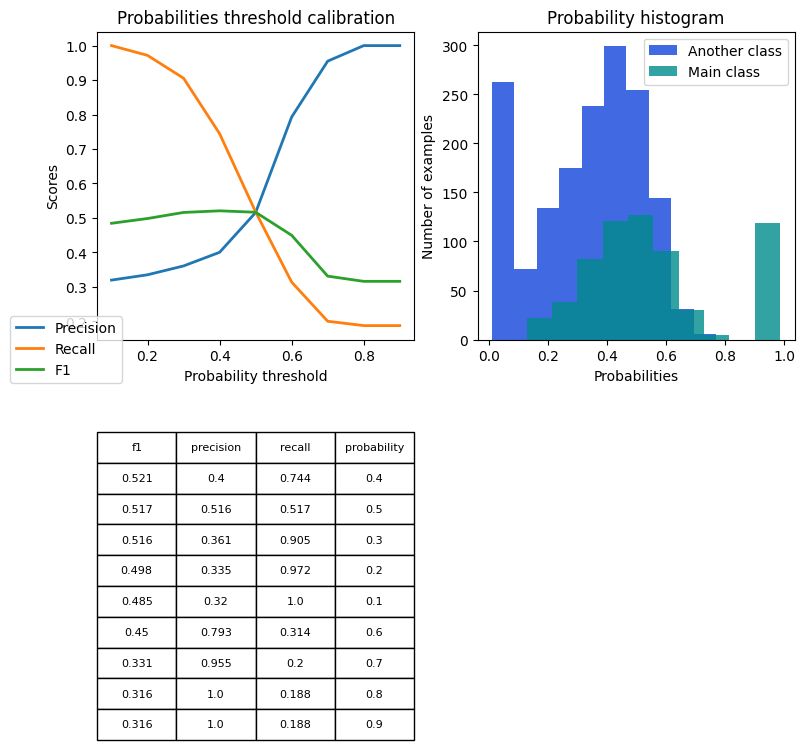

In [58]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

###Прогно3

In [59]:
forecast = final_model.predict(test_df[NUM_FEATURE_NAMES_])

In [60]:
my_forecast = pd.DataFrame({'Credit Default': forecast.flatten()}, columns = ['Credit Default'])

In [61]:
my_forecast.head(10)

,Credit Default
0,0
1,0
2,1
3,0
4,0
5,0
6,1
7,1
8,1
9,0


In [62]:
my_forecast.shape

(2500, 1)

In [63]:
my_forecast.to_csv(MPozdnyakova_predictions, sep = ',', index = False, encoding = 'utf-8')